In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc
import pandas as pd
import seaborn as sb

plt.rcParams["figure.figsize"] = (7, 7)
import numpy as np

sc.settings.verbosity = 3

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [7]:
## Define color palette
pal = sb.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
import os,sys

figdir = './'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [9]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [10]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [11]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

# Set up anndata

In [13]:
adata = sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/adata_mm_OL_NEW.h5ad')
adata

AnnData object with n_obs × n_vars = 44794 × 19913
    obs: 'sample_id', 'publication', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'type_fine', 'type_broad', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'leiden_OL_r1.5', 'individual_lesion_condition', 'OL_broad', 'OL_broad_MOLs', 'OL_leiden_annotated_new', 'minimal_treatment_map', 'OL_fine_type', 'OL_leiden_annotated', 'cell_type', 'OL_fine_type_NEW', 'OL_noDAO_NEW', 'OL_noDAO_NEW_NUMBERED', 'OL_noDAO_NUMBERED', 'OL_noDAO_LETTER'
    var: 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'OL_broad_MOLs_colors', 'OL_broad_MOLs_sizes', 'OL_broad_colors', 'OL_broad_sizes', 'O

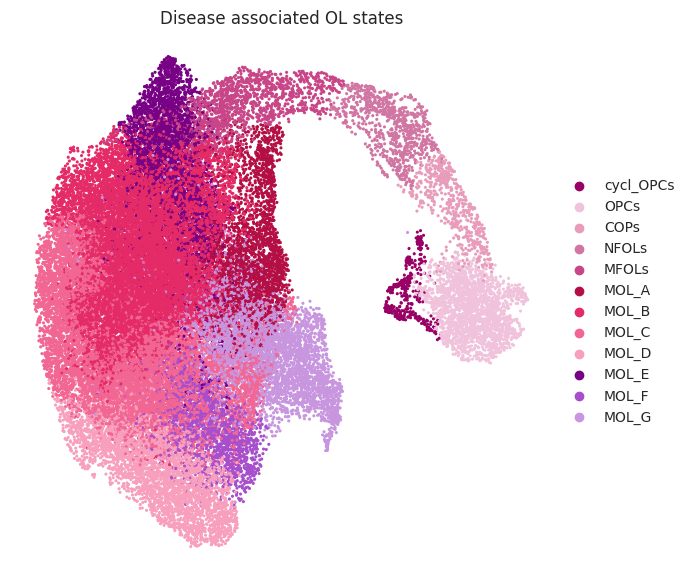

In [14]:
cluster_color = {
    'MOL_A': '#b40f44',
    'MOL_B': '#e42b67',
    'MOL_C': '#f26694',
    'MOL_E': '#770084',
    'MOL_G': '#c895df',
    'MOL_D': '#f79fbc',
    'MFOLs': '#c84688',
    'OPCs': '#f0c2db',
    'MOL_F': '#a74ecd',
    'NFOLs': '#d175a3',
    'COPs': '#e89cb9',
    'cycl_OPCs': '#990066'
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['OL_noDAO_NEW'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color,s=20,
           legend_fontweight= 'bold', title='Disease associated OL states', frameon= False , 
           legend_fontoutline=1)# save=today+'_annotated_OL_fine_NEW.pdf')

In [15]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['OL_noDAO_NEW'].unique()
for condition in unique_conditions:
    print(condition)

MFOLs
OPCs
NFOLs
MOL_E
COPs
cycl_OPCs
MOL_F
MOL_D
MOL_B
MOL_C
MOL_G
MOL_A


## Start MILO analysis-- LPC samples

In [16]:
## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 44794 × 19913
  2 modalities
    rna:	44794 x 19913
      obs:	'sample_id', 'publication', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'type_fine', 'type_broad', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'leiden_OL_r1.5', 'individual_lesion_condition', 'OL_broad', 'OL_broad_MOLs', 'OL_leiden_annotated_new', 'minimal_treatment_map', 'OL_fine_type', 'OL_leiden_annotated', 'cell_type', 'OL_fine_type_NEW', 'OL_noDAO_NEW', 'OL_noDAO_NEW_NUMBERED', 'OL_noDAO_NUMBERED', 'OL_noDAO_LETTER'
      var:	'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'OL_broad_MOLs_colors', 'OL_broad_MOLs_sizes', 'OL_broad_colors', 'OL_broad_sizes', 'OL_fine_type_NEW_colors', 'OL_fine_type_colors', 'OL_fine_type_sizes', 'OL_leiden_annotated_colors', 'OL_noDAO_LETTER_colors', 'OL_noDAO_NEW_NUMBERED_colors', 'OL_noDAO_NEW_colors', 'OL_noDAO_NUMBERED_colors', 'cell_type_colors', 'cell_type_sizes', 'dendrogram_OL_broad', 'dendrogram_OL_fine_type', 'dendrogram_OL_fine_type_NEW', 'dendrogram_OL_noDAO_LETTER', 'dendrogram_OL_noDAO_NEW', 'dendrogram_leiden_OL_r1.5', 'leiden_OL_r1.5_colors', 'minimal_treatment_map_colors', 'neighbors', 'paga', 'publication_colors', 'rank_genes_OL_broad'
      obsm:	'X_pca', 'X_sysVI', 'X_umap', 'covariates', 'system'
      layers:	'counts', 'log1p_norm', 'scaled'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [17]:
sc.pp.neighbors(mdata["rna"], use_rep="X_sysVI", n_neighbors=100)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)


In [18]:
milo.make_nhoods(mdata["rna"], prop=0.1)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.4697585 3.0014534 3.5173078 ... 2.126872  2.6984985 2.1629329]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


In [19]:
mdata['rna'].obsm

AxisArrays with keys: X_pca, X_sysVI, X_umap, covariates, system, nhoods

In [20]:
mdata["rna"].obsm["nhoods"]

<44794x3838 sparse matrix of type '<class 'numpy.float32'>'
	with 636757 stored elements in Compressed Sparse Row format>

In [21]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

,nhood_ixs_refined,nhood_kth_distance
barcode,,
TCACGCTCACTACTTT-1_adams,1,3.469759
TGAGGAGCAGGACTTT-1_adams,1,3.001453
CGGGTGTGTCGTACTA-1_adams,1,3.517308
TTCTGTATCAGGACGA-1_adams,1,3.220697
GGGTCTGCATGACTAC-1_adams,1,3.921180
...,...,...
AAGGAGCGTTCACGGC-1-1_shen,1,2.131313
CTAAGACGTGTGGTTT-1-1_shen,1,2.084162
TGTATTCCAGAAGCAC-1-1_shen,1,2.126872


Text(0, 0.5, '# nhoods')

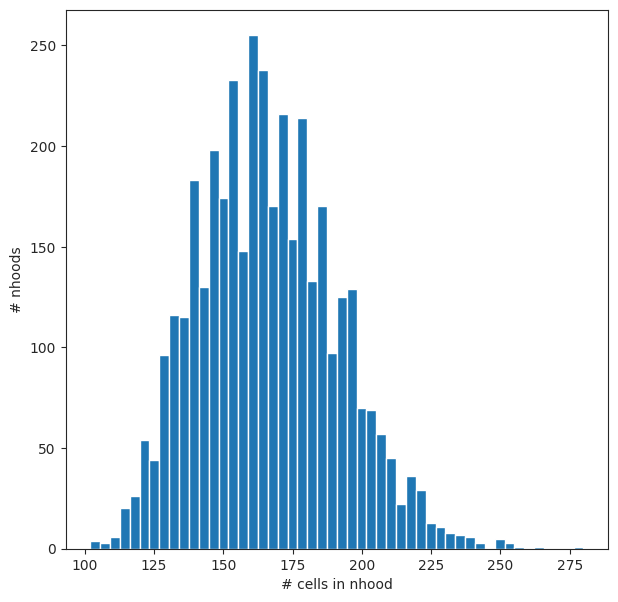

In [22]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods")

In [23]:
np.median(nhood_size)
#Want 5*number of samples 

164.0

In [24]:
mdata = milo.count_nhoods(mdata, sample_col="sample_id")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [25]:
mdata["milo"]

AnnData object with n_obs × n_vars = 30 × 3838
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

# Set up comparison

In [26]:
# Update the 'treatment_meta' column based on the mapping
mdata["rna"].obs['status'] = mdata["rna"].obs['lesion_status']

In [27]:
# Convert the 'status' column to categorical dtype first
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].astype("category")

# Now reorder the categories as you were trying to do
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].cat.reorder_categories([
    "LPC_baseline", "LPC_demyel", "LPC_mid_remyel", "LPC_remyel", "Cupr_baseline", "Cupr_demyel", "Cupr_remyel"], ordered=True)

In [28]:
milo.da_nhoods(
    mdata, design="~status", model_contrasts="statusCupr_remyel-statusCupr_baseline"
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


In [29]:
mdata["milo"]

AnnData object with n_obs × n_vars = 30 × 3838
    obs: 'status', 'sample_id'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR'
    uns: 'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

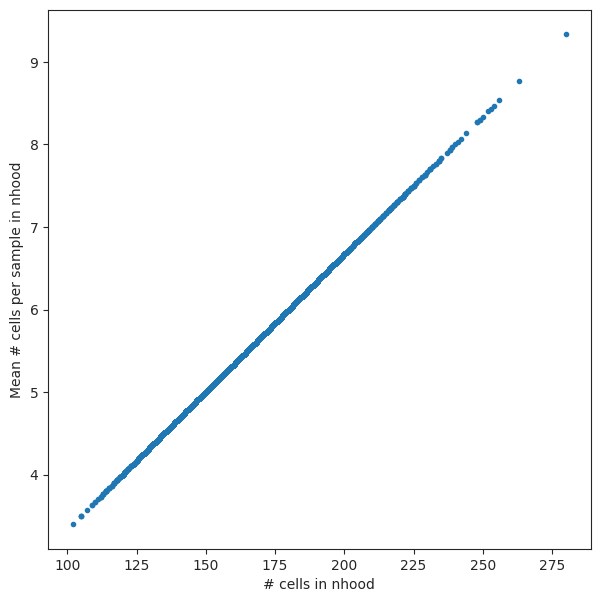

In [30]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

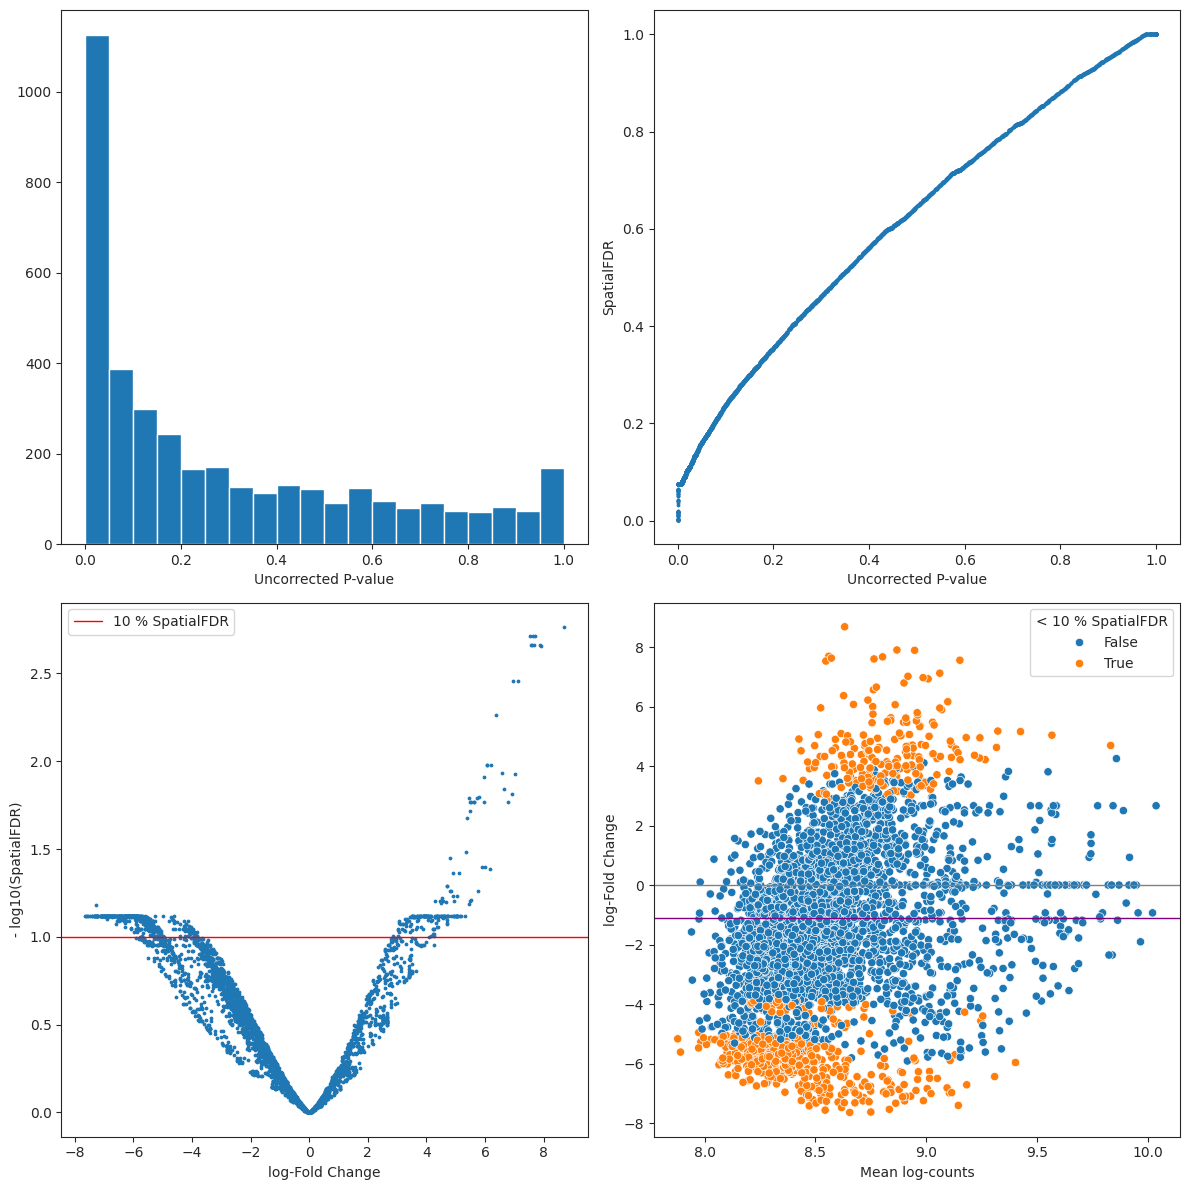

In [31]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sb.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

# Visualize results on embedding

In [32]:
milo.build_nhood_graph(mdata)

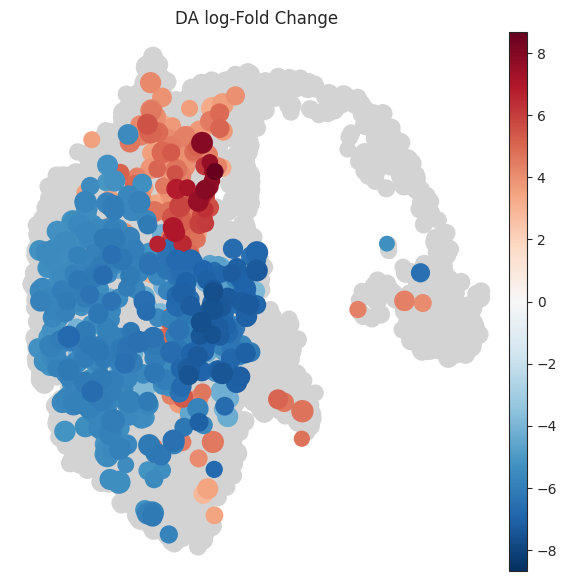

In [33]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  ## SpatialFDR level (0.1%)
    min_size=5,  ## Size of smallest dot
    plot_edges=False,
    save='_Cupr_remyel.png'
)

# Visualize by cell type

In [34]:
milo.annotate_nhoods(mdata, anno_col="OL_noDAO_NEW")

Text(0.5, 0, 'celltype fraction')

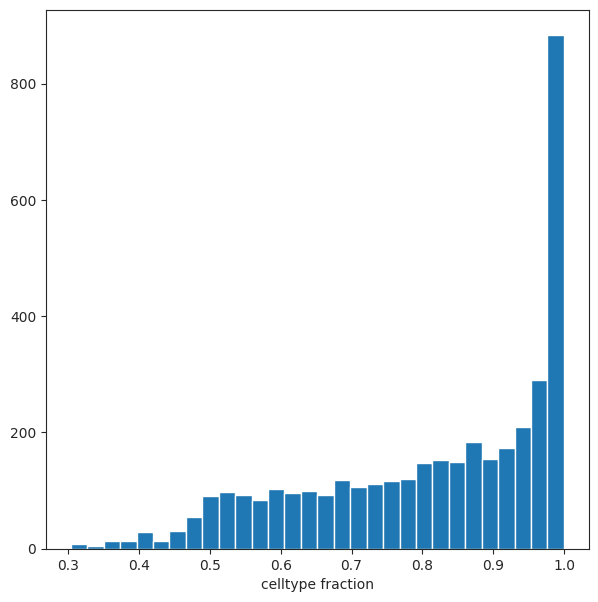

In [35]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [36]:
# Check current categories of 'nhood_annotation'
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories

# Add new category 'Mixed' if it doesn't already exist
if "Mixed" not in current_categories:
    mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")

# Now assign "Mixed" to rows where 'nhood_annotation_frac' < 0.6
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:908: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_adata.obs[[anno_col, "logFC"]].groupby(anno_col).median().sort_values("logFC", ascending=True).index
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:925: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:925: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the 

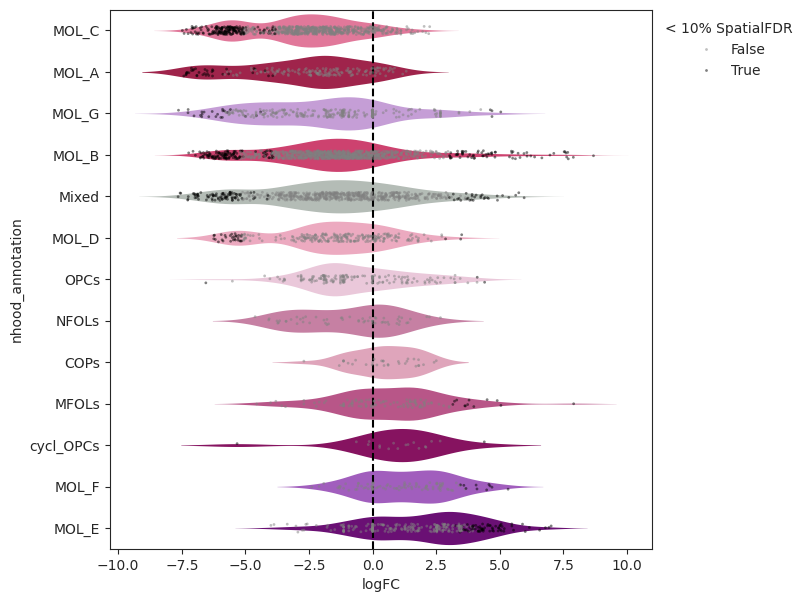

In [37]:
cluster_color = {
    'MOL_A': '#b40f44',
    'MOL_B': '#e42b67',
    'MOL_C': '#f26694',
    'MOL_E': '#770084',
    'MOL_G': '#c895df',
    'MOL_D': '#f79fbc',
    'MFOLs': '#c84688',
    'OPCs': '#f0c2db',
    'MOL_F': '#a74ecd',
    'NFOLs': '#d175a3',
    'COPs': '#e89cb9',
    'cycl_OPCs': '#990066',
    'Mixed': '#b2beb5'
}

# Ensure all categories including 'Mixed' are in the nhood_annotation
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories
desired_categories = list(cluster_color.keys())

for cat in desired_categories:
    if cat not in current_categories:
        mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories(cat)

# Now plot with custom colors
milo.plot_da_beeswarm(mdata, alpha=0.1, 
                      palette=cluster_color,
                     save='_Cupr_remyel_ALL.png')

# Alternate beeswarm

In [38]:
nh_df = mdata["milo"].var.copy()
nh_df

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Sig,Nhood_size,nhood_annotation,nhood_annotation_frac
0,TCACGCTCACTACTTT-1_adams,3.469759,-0.170993,9.086145,0.006111,0.937774,0.986346,0.976004,False,171.0,NFOLs,0.988304
1,TGAGGAGCAGGACTTT-1_adams,3.001453,-0.409143,9.070912,0.077780,0.780635,0.878615,0.867724,False,190.0,MFOLs,1.000000
2,CGGGTGTGTCGTACTA-1_adams,3.517308,-3.400883,8.946654,1.797907,0.181560,0.352173,0.335122,False,151.0,NFOLs,1.000000
3,TTCTGTATCAGGACGA-1_adams,3.220697,-0.795454,8.964912,0.256582,0.613061,0.751015,0.738534,False,167.0,MFOLs,0.982036
4,GGGTCTGCATGACTAC-1_adams,3.921180,-4.010211,8.762591,2.407929,0.122444,0.283759,0.266383,False,136.0,MFOLs,0.926471
...,...,...,...,...,...,...,...,...,...,...,...,...
3833,AAGGAGCGTTCACGGC-1-1_shen,2.131313,-2.200264,8.609933,1.660809,0.199372,0.372536,0.354537,False,160.0,MOL_A,1.000000
3834,CTAAGACGTGTGGTTT-1-1_shen,2.084162,-3.839482,8.795370,3.570867,0.060669,0.188068,0.176358,False,169.0,MOL_A,0.994083
3835,TGTATTCCAGAAGCAC-1-1_shen,2.126872,-1.196605,8.811960,0.591027,0.443146,0.620511,0.600678,False,211.0,MOL_A,0.985782
3836,GTACTCCAGGAGTAGA-1_shen,2.698498,-3.905575,8.169326,5.478202,0.020323,0.109853,0.103481,False,118.0,MOL_A,0.949153


In [39]:
%%R -i nh_df
head(nh_df)

                index_cell kth_distance      logFC   logCPM           F
0 TCACGCTCACTACTTT-1_adams     3.469759 -0.1709931 9.086145 0.006110597
1 TGAGGAGCAGGACTTT-1_adams     3.001453 -0.4091426 9.070912 0.077780004
2 CGGGTGTGTCGTACTA-1_adams     3.517308 -3.4008833 8.946654 1.797907386
3 TTCTGTATCAGGACGA-1_adams     3.220697 -0.7954542 8.964912 0.256581649
4 GGGTCTGCATGACTAC-1_adams     3.921180 -4.0102113 8.762591 2.407929466
5 TATTGGGCATGACTAC-1_adams     2.353066  0.1896047 8.468246 0.009589358
     PValue       FDR SpatialFDR   Sig Nhood_size nhood_annotation
0 0.9377736 0.9863456  0.9760036 FALSE        171            NFOLs
1 0.7806347 0.8786147  0.8677240 FALSE        190            MFOLs
2 0.1815598 0.3521729  0.3351217 FALSE        151            NFOLs
3 0.6130611 0.7510146  0.7385343 FALSE        167            MFOLs
4 0.1224438 0.2837589  0.2663832 FALSE        136            MFOLs
5 0.9220981 0.9753202  0.9645209 FALSE        133            Mixed
  nhood_annotation_frac
0  

In [40]:
nh_df.to_csv('nh_df_Cupr_remyel_ALL_DATA.csv', index=True)  # index=True to include row names

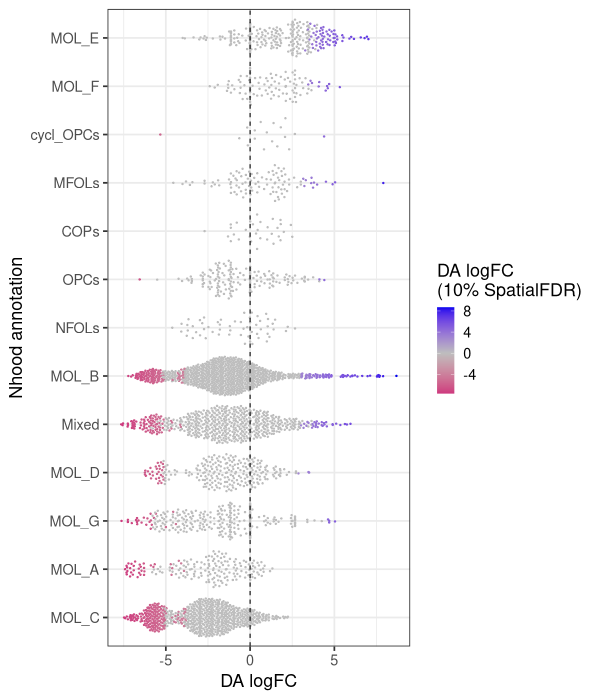

In [41]:
%%R -h 700 -w 600

#figdir <- './sysVI_mm_OL_figures/'

nh_df %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 0.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width = 10, height = 12) +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width = 10, height = 12)